In [8]:
import matplotlib.pyplot as plt
import pandas as pd
import tweepy

%matplotlib inline
pd.options.display.mpl_style = 'default'
%config InlineBackend.figure_format='retina'

# Introduction

Caltrain experiences occasional (or frequent, depending on your perspective) system-level perterbations which make train arrival/departure unpredictable. Caltrain itself turns off their real-time API during these events, which we label "FOOBAR". FOOBAR events include:
* pedestrian strikes
* vehicle strikes
* stalled trains

These events are unpredictable in frequency and duration. Not all pedestrian strikes or stalls result in FOOBAR, however. A recent suicide at Santa Clara caused the train involved to be suspended, but other trains could pass unhindered because of the extra track available at that station.

There are other times when train delays are longer than is typical because of externalities, like
* major sporting events
* 'heavy ridership'
* busy holiday weekends
* construction

These are often known in advance, but the exact effect on train delays would be difficult to predict accurately. For example, a Giants game against the Cubs vs the Yankees (no offense John...) In essence, you would have to train a predictor on the effect of all revelant external events.

Let us simplify the problem: the cause of a delay is not predictable, but its effect through the system could be. FOOBAR events are neither predictable in cause (when) nor effect (how long). The purpose of this analysis is to determine ways in which we might be able to exclude them. In contrast, we say heavy delays are not predictible in cause (when) but _are_ predictible in effect (how delays propogate), and have yet to be studied.

Since a predictive model cannot predict noise or unpredictable events, any train prediction scheme we concoct must fail gracefully and recover reliably (these need specific definitions).

There are then two purposes to identifying catastrophic events in historical data:
1. Exclude them from predictible events for model training purposes
2. Understand how to identify them in real-time so the prediction service can handle system failures and recoveries gracefully

As usual in the initial stages, this was done manually by inspecting Caltrain's twitter feed and looking through historical real-time API results. During a 10 day period in October, there were 4 [major incidents](#Events), 3 of which caused service interruptions and major delays.


## Analysis

* Two twitter sources: @caltrian_news (official twitter acct) and 'caltrain' search feed
* Twitter Search API only returns ~week of data

### Load tweets

In [ ]:
caltrain_tweets = pd.json.load(open('caltrain_tweets.json'))

### Download tweets

In [9]:
auth = tweepy.OAuthHandler('YdJkmn4WO3NZEzXZByRGyw', 'xOp6B7uPYAJGoLnnxqY7f0MdZvbWB4GEVDyGofBC0')

auth.set_access_token('44573375-g4dUXD7qDFB8aWH3Ii5zvLcPm8RUr9mPA4vlvrJQ',
                      'NlzyrXDUyr2hhl1q1cbm35dz1cdGAzTNlHzG3K1bg')

api = tweepy.API(auth)

In [644]:
def get_user_tweets(user, N, page_size=200, max_id=None):
    assert page_size <= 200
    pages = tweepy.Cursor(api.user_timeline, id='caltrain_news', count=page_size, max_id=max_id).pages()
    tweets = []
    while len(tweets) < N:
        count = min(page_size, N-len(tweets))
        page = next(pages)
        tweets.extend(page[:count])
    return tweets

In [13]:
caltrain_tweets = get_user_tweets('caltrain_news', 1000)

In [32]:
# Save tweets
pd.json.dump(caltrain_tweets, open('caltrain_tweets.json', 'w'))

### Status (not reply or retweet)

In [640]:
def is_reply(tweet):
    return tweet.in_reply_to_user_id is not None

def is_retweet(tweet):
    txt = tweet.text.lower()
    return txt.startswith('rt')

In [641]:
status = [ tweet for tweet in caltrain_tweets if (not is_reply(tweet) and not is_retweet(tweet))]

In [642]:
len(status)

571

### Simplify status tweets to datetime + text

In [655]:
def get_attrs(lst, *attrs):
    from operator import attrgetter
    return list(map(attrgetter(*attrs), lst))

# list(get_attrs(status[:10], 'created_at', 'text'))

In [537]:
created_at, text = zip(*get_attrs(status, 'created_at', 'text'))

df = pd.DataFrame({'text': text}, 
                  index=created_at,
                 ).sort_index()

df.text = df.text.str.lower()
df.index = df.index.tz_localize('UTC').tz_convert(api.me().utc_offset)

## Keywords

Flag certain words as potentially indicating failure or excessive delays. The advantage over NLP approaches is that as a human I need a much smaller training set!

In [667]:
failure_words = ['pedestrian', 
                 'vehicle',
                 'stalled train']

delay_words = ['heavy ridership', 
               'emergency incident',
               'reduced speed', 'restricted speed',
               'expect delays',
               'min late', 'mins late',
               'switch issue', 'switching issue'
              ] + failure_words
          

def contains_one_of(s, words):
    for word in words:
        if word in s:
            return True
    return False

delayed = lambda s: contains_one_of(s, delay_words)
failed = lambda s: contains_one_of(s, failure_words)

In [668]:
df['delay'] = df.text.apply(delayed)
df['failure'] = df.text.apply(failed)
df['tweet'] = True

## All caltrain mentions

Use the Search API to get all tweets with "caltrain" for the last few days (twitter limits time period of search results.)

In [24]:
def get_tweets(api, *args, **kwargs):
    N = kwargs.pop('N', 50)
    page_size = kwargs.pop('page_size', 200)
    assert page_size <= 200
    pages = tweepy.Cursor(api, *args, count=page_size, **kwargs).pages()
    tweets = []
    for page in pages:
        count = min(page_size, N-len(tweets))
        tweets.extend(page[:count])
        if count < page_size:
            break
    return tweets

In [25]:
# Load saved tweets
all_tweets = pd.json.load(open('all_tweets.json'))

## Example: search api

# all_tweets = get_tweets(api.search, 'caltrain', N=10000)
# pd.json.dump(all_tweets, open('all_tweets.json', 'w'))

In [60]:
len(all_tweets)

4363

In [727]:
all_tweets_text = pd.DataFrame(get_attrs(all_tweets, 'created_at', 'user.screen_name', 'text'), 
                               columns=['created_at', 'screen_name', 'text']
                              ).set_index('created_at')
all_tweets_text.head()

,screen_name,text
created_at,,
2015-10-19 20:37:12,caltrain_69,"OK, now I think the UK needs to launch air strikes in Syria. https://t.co/Dyh7tNuXvs"
2015-10-19 20:34:05,CaltrainReports,When #Caltrain has an incident they say it'll probably take 30 to 90 minutes to fix. #sfBART says only 10 minutes in...
2015-10-19 20:29:47,GeorgeJLee,"Enough is enough, I'm shredding my Clipper card and starting over. Already spent too much time trying to sorting out..."
2015-10-19 20:25:23,FioraAeterna,"@Eldritchreality caltrain is unusually bad. it's ridiculously heavy, screechy, slow, and lots of other bad words"
2015-10-19 20:16:30,CaltrainReports,"Other #Caltrain-names for @OnTheCaltrain: InTheCaltrain, GluedToCaltrain, CaltrainUpdates, CaltrainOMGWAGD, NewsOfCa..."


In [729]:
all_tweets_text.index = all_tweets_text.index.tz_localize('UTC').tz_convert(api.me().utc_offset)

In [781]:
all_tweets_text['delay'] = all_tweets_text.text.apply(delayed)
all_tweets_text['failure'] = all_tweets_text.text.apply(failed)

In [779]:
all_tweets_text.sort_index().ix['2015-10-13 22:35':].head(20)

,screen_name,text,delay,failure
created_at,,,,
2015-10-13 22:35:37-07:00,Druthersco,"By cindobindo Tonight on the Caltrain, thanks to the amazing folks at @designerfund, I'm reading @jessicahische's n…...",False,False
2015-10-13 22:42:38-07:00,garrett_gleaton,"RT @SimonOh: A nightmarish afternoon for Bay Area commuters: @Caltrain_News in San Mateo, @VTA light rail in San Jos...",False,False
2015-10-13 22:49:19-07:00,garrett_gleaton,"RT @jbqueru: Train accident on Amtrak, train accident on Caltrain, train accident on VTA light rail. Next, a car fal...",False,False
2015-10-13 22:53:10-07:00,petitechristine,"Accidents/deaths at BART, Caltrain, and VTA today? #yikes",False,False
2015-10-13 23:03:08-07:00,tehjarr,Let's take a minute to recognize &amp; praise the acerbic wit and humanity behind the @Caltrain_News Twitter. Bravo.,False,False
2015-10-13 23:17:19-07:00,reggie4anything,"RT @ChadricIsLike: Man, someone pulled the strap out at City, someone died on BART &amp; on Caltrain, Lamar Odom unc...",False,False
2015-10-13 23:23:08-07:00,michaelcoyote,@alevin Even infill around Laurence or Sunnyvale Caltrain could be a great fit for a company looking to consolidate....,False,False
2015-10-13 23:28:20-07:00,joshuahmel,RT @trainridersCA: Palo Alto looks at Caltrain grade separation options including trenches... http://t.co/P6bMTcwVEt,False,False
2015-10-13 23:49:24-07:00,alxndghall,When people get hurt and trains get super passive aggressive. #siliconvalley #caltrain https://t.co/6dQVNDVqns,False,False


### Tweet rates

Tweets are downsampled to tweets per 10 min, and then rolling window average over 60 minutes. So final units are tweets per 10 min over last 60 min (updated every 10 minutes.)

Below are rates for
- all @caltrain_news tweets
- @caltrain_news tweets that indicate delays
- @caltrain_new tweets that indicate failures

Note that the event on the 10th did not cause a system interruption, and no failure words were seen.

The simple failure keyword scheme missed the event on the 12th (a stalled train). Another form of reporting (shown below) is also clearly indicates system-wide delays, but there's no standard that is easily parsed. Even the example below says mins in one and uses " for others.

In [845]:
print(df.ix['2015-10-12':'2015-10-12'].iloc[4].text)

228 running local schedule making all stops.
324 delayed 32 mins
226 delayed 27”
228 delayed 16”
230 delayed 7"
#caltrain


/Users/christian/miniconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


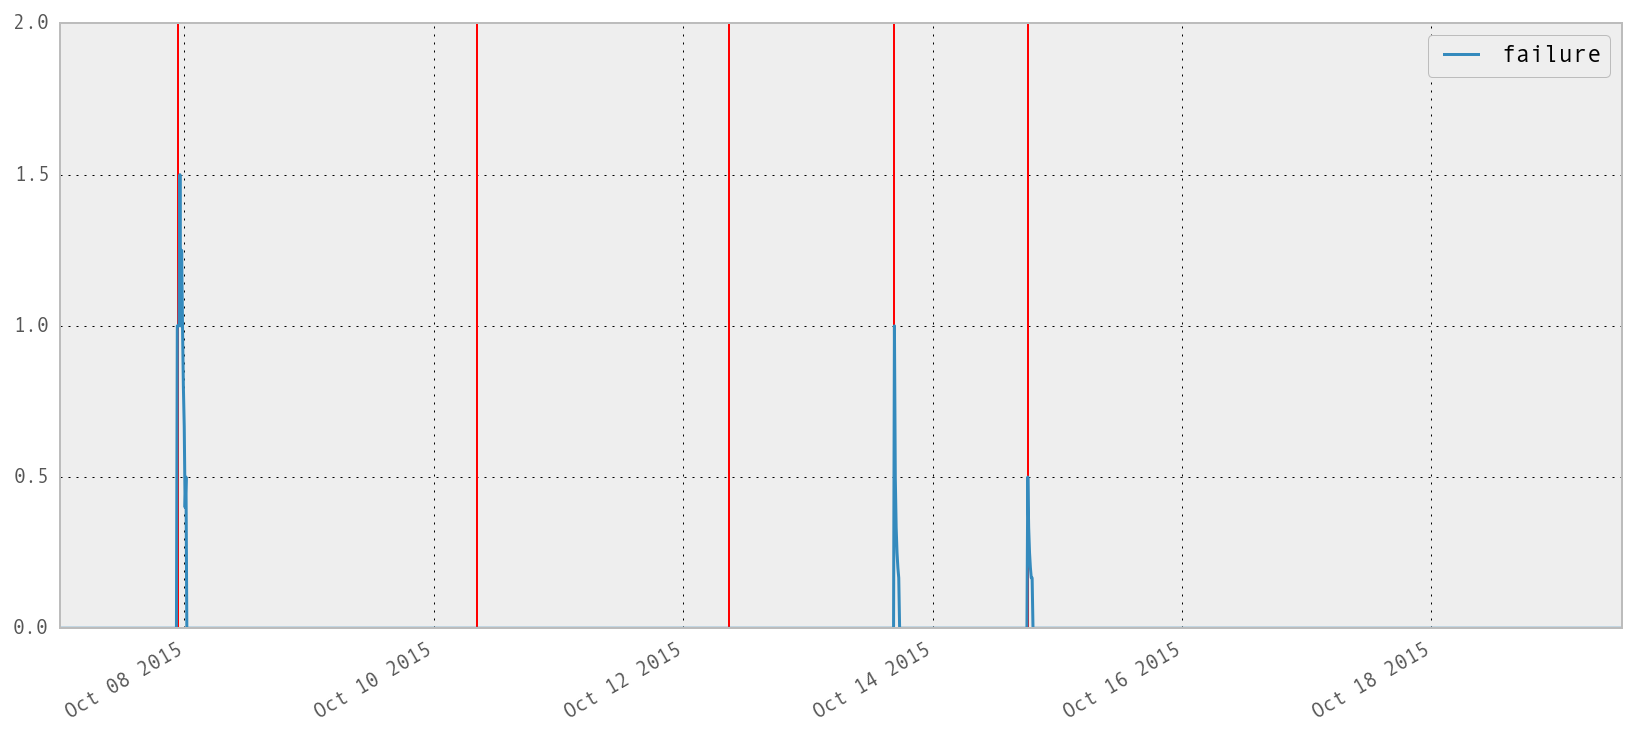

In [836]:
caltrain_tweets_rate = pd.rolling_mean(df, 6, min_periods=1, freq='10Min', how='sum')

(caltrain_tweets_rate[['failure']].ix['2015-10-07':]
 .fillna(0)
 .plot(style='-', linewidth=1.5, figsize=(14,6))
)

plt.vlines(['2015-10-07 22:45:14-07:00', '2015-10-10 08:19-0700', '2015-10-12 08:55-0700', '2015-10-14 18:18-0700', '2015-10-13 16:40-0700'], 
           0, 2, colors='r')

In [838]:
# Events from Oct 12
df.ix['2015-10-12':'2015-10-12']

,text,delay,failure,has_text
2015-10-12 08:55:28-07:00,#sb324 is stalled. we are working to troubleshoot the issue. may cause delays. #caltrain,False,False,True
2015-10-12 08:59:24-07:00,#sb324 will couple with 226. 228 will pass. #caltrain,False,False,True
2015-10-12 09:01:03-07:00,"228 arriving sbr on the northbound platform, overtaking 226 and 324.\n \n324 delayed 27 mins. \n226 delayed 21”\n228...",False,False,True
2015-10-12 09:10:11-07:00,#sb324 and #sb226 are connected and preparing to move. #caltrain,False,False,True
2015-10-12 09:11:22-07:00,"228 running local schedule making all stops.\n324 delayed 32 mins\n226 delayed 27”\n228 delayed 16”\n230 delayed 7""\...",False,False,True
2015-10-12 09:12:29-07:00,230 arriving on northbound platform at sbr. will overtake 226/324.\n324 delayed 40 mins late\n226 delayed 33”\n228 ...,True,False,True
2015-10-12 09:26:47-07:00,226 coupled to 324. #sb324 terminated. 226 combining stops with 324. on the move south. #caltrain,False,False,True
2015-10-12 09:28:46-07:00,226 delayed 43 mins late.\n228 delayed 17”\n230 delayed 12”\n#caltrain,True,False,True
2015-10-12 09:29:40-07:00,"324/226 combo will be making double stops at stations, letting out first half, then moving up for second half.",False,False,True
2015-10-12 09:32:10-07:00,228 making all stops. overtook 226/324. \n230 &amp; 332 overtook 226/324.\n324 terminated\n226 delayed 50”\n228 de...,False,False,True


**Tweet rate for all tweets which contain 'caltrain' (includes #caltrain and @caltrain_news, etc.)**

Calculate number of tweets in 10 min intervals, and also look at 60 minute rolling average for caltrain search term tweets, as well as those subsets that have failure or delay keywords.

Known events are indicated by vertical black bar, and correlate with increase in caltrain mentions on twitter. The 3rd plot is zoomed in on one event to illustrate the rise time of the rolling average.

Failure words seem not as clear a signal in this context compared to the @caltrain_news only feed.

In [692]:
# Create a time series with only values of 1
dt = pd.Series(1, index=get_attrs(all_tweets, 'created_at'))

# Convert from UTC to my twitter profile local time
dt.index = dt.index.tz_localize('UTC').tz_convert(api.me().utc_offset)

/Users/christian/miniconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


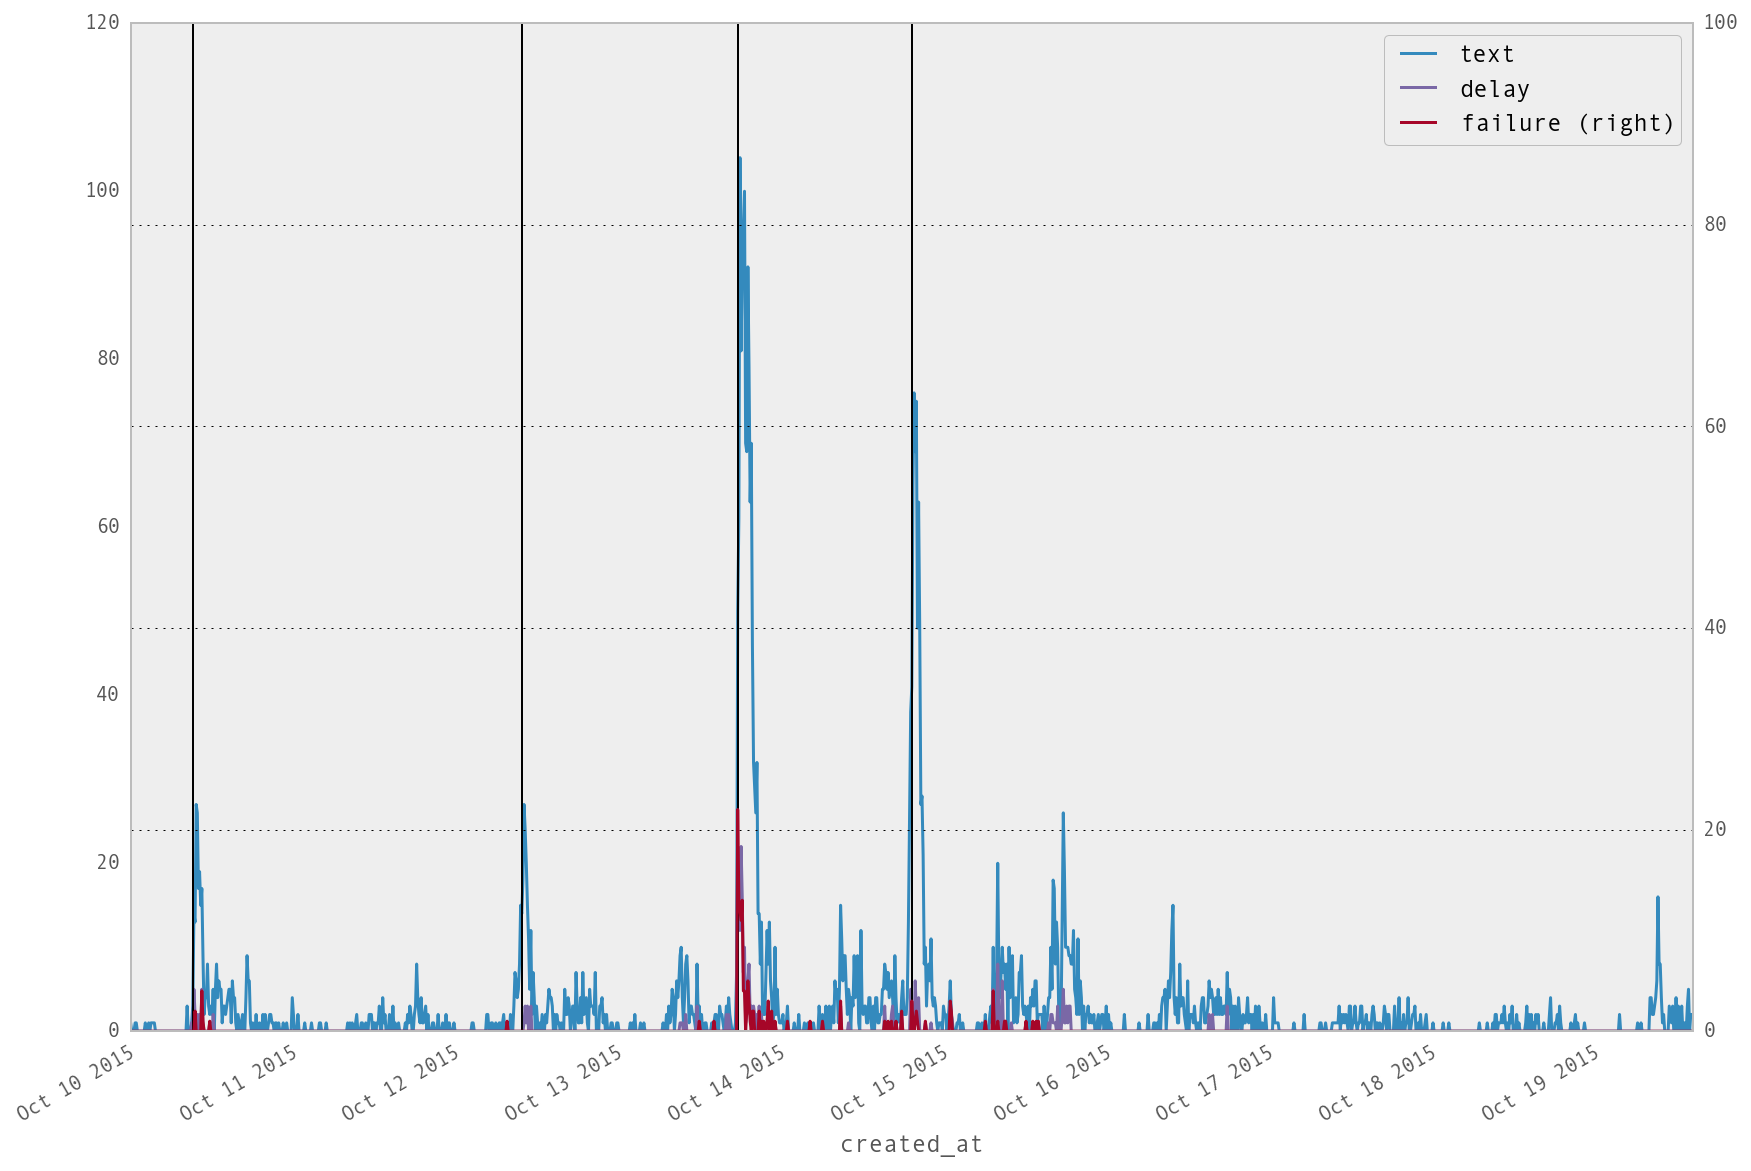

In [816]:
(all_tweets_text.drop('screen_name', axis=1).astype(bool)
 .resample('10Min', how='sum').fillna(0)
 .plot(style='-', figsize=(14,10), secondary_y=['failure'], linewidth=1.5)
)

plt.vlines(['2015-10-10 08:19-0700', '2015-10-12 08:55-0700', '2015-10-14 18:18-0700', '2015-10-13 16:40-0700'], 0, 100)

/Users/christian/miniconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


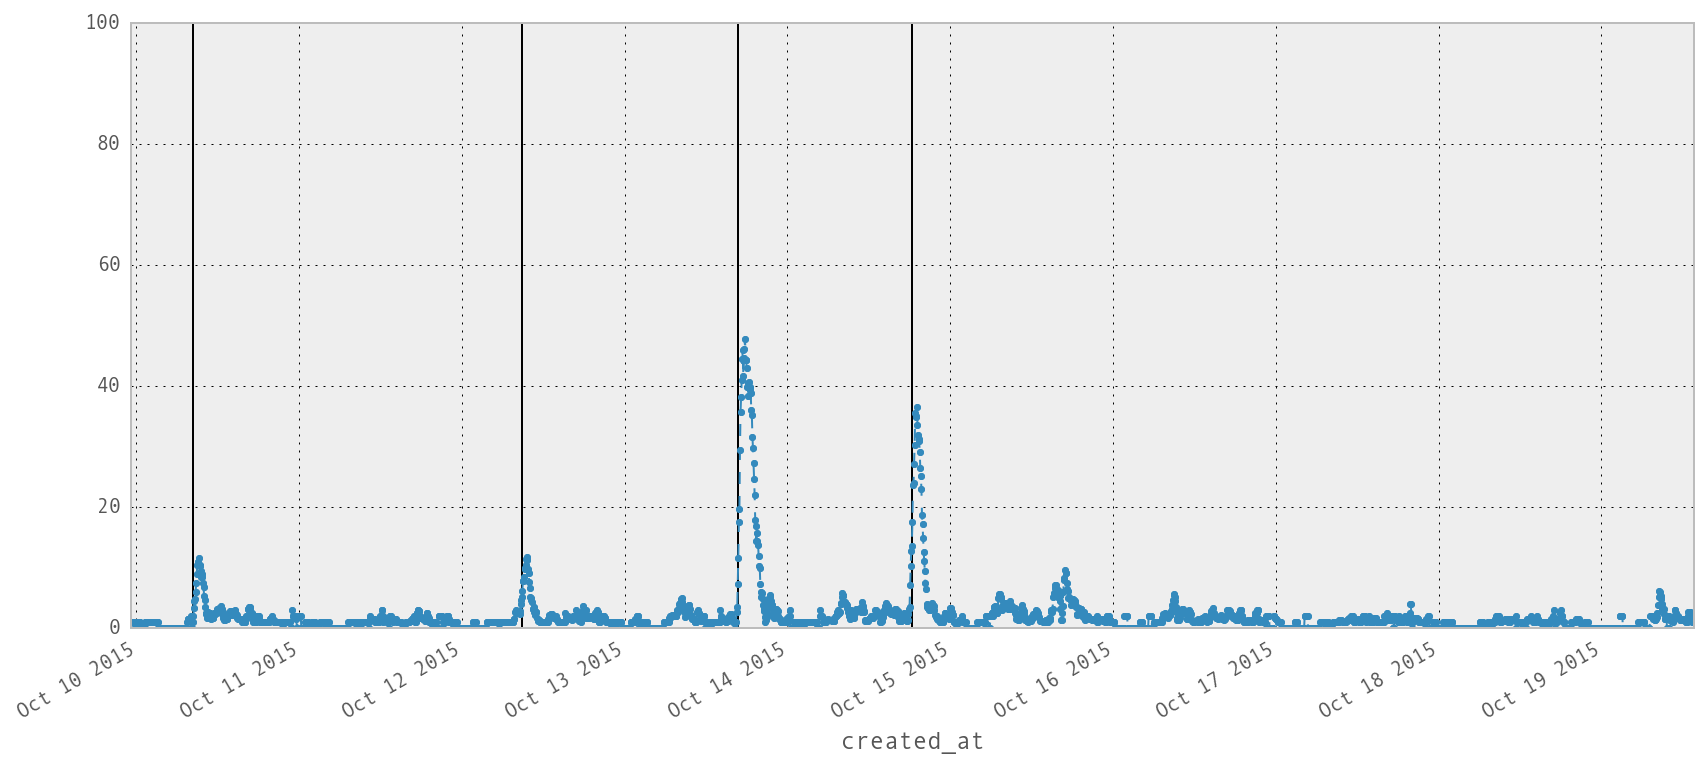

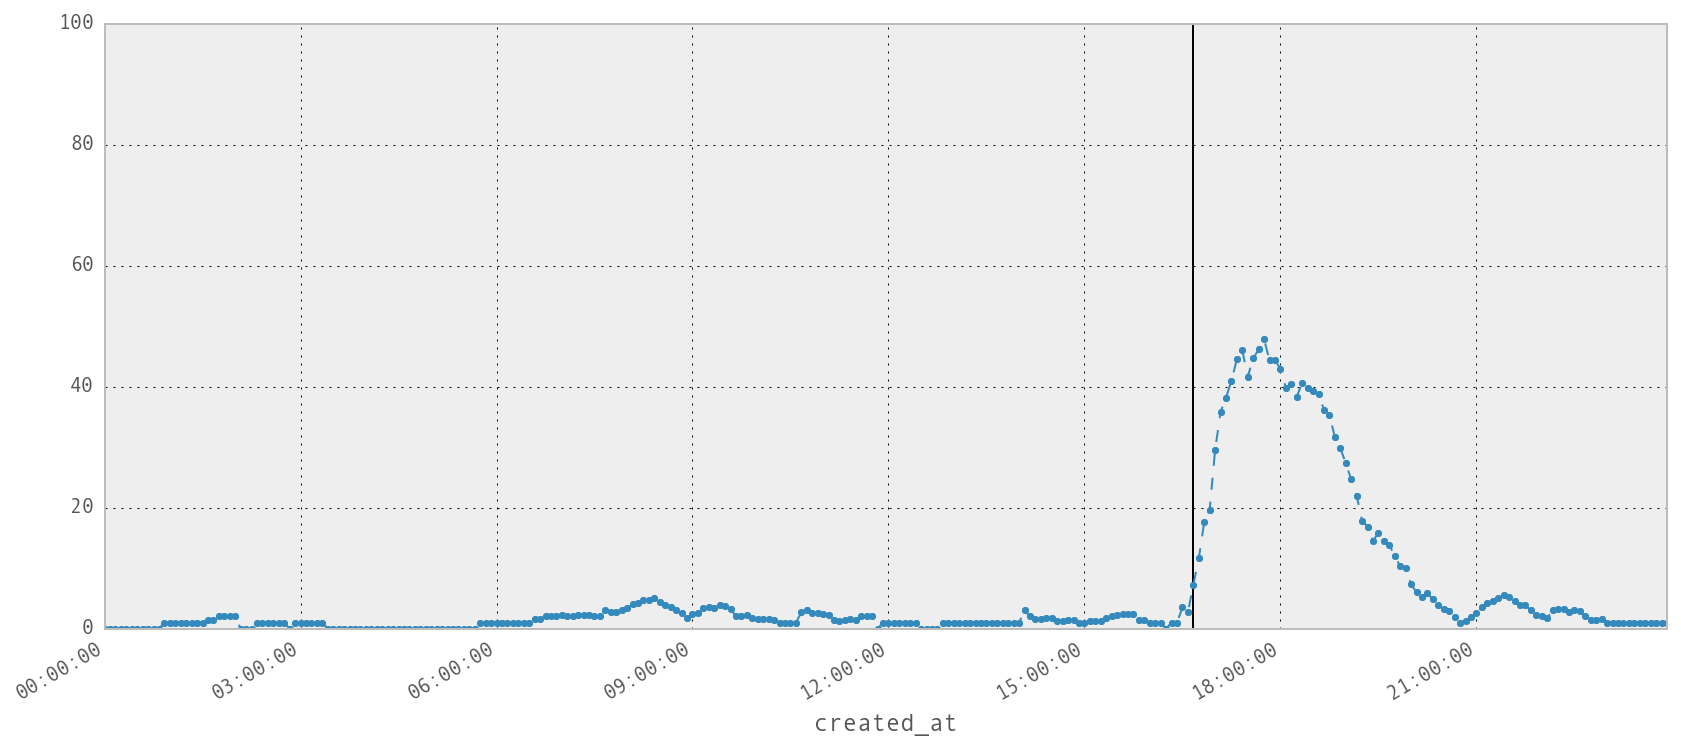

In [821]:
tweets_per_hour = pd.rolling_mean(all_tweets_text.text.apply(lambda s: int(s is not None)), 
                                  window=6, min_periods=1, 
                                  freq='5Min', how='sum').fillna(0)

from IPython.display import display
display(tweets_per_hour.plot(style='--.', figsize=(14,6)))
plt.vlines(['2015-10-10 08:19-0700', '2015-10-12 08:55-0700', '2015-10-14 18:18-0700', '2015-10-13 16:40-0700'], 0, 100)

plt.figure()
display(tweets_per_hour.ix['2015-10-13':'2015-10-13'].plot(style='--.', figsize=(14,6)))
plt.vlines(['2015-10-10 08:19-0700', '2015-10-12 08:55-0700', '2015-10-14 18:18-0700', '2015-10-13 16:40-0700'], 0, 100)

### Events

* **Oct 07 10:45 pm**
    - 197 struck a vehicle at bayswater ave
* **Oct 10 8:19 am**
    - 423 stopped due to 'emergency incident'
    - no other affected trains according to twitter
* **Oct 12 8:55am**
    - SB324 stalled (didn't say where in twitter) and coupled to 324
    - 20 to 60 min delay (longest for stalled train + 324)
* **Oct 13 4:43 pm**
    - pedestrian incident at San Mateo, 261
    - Transit PD stopped single tracking so both ways were jammed
    - incident train was cancelled, 30-60+ minute delays
    - 282, 284, and 386 departed late from SF
    
* **Oct 14 6:18 pm:** 
    - stalled train 273 near Millbrae
    - delays ~20-40 minutes (NB trains behind stall were on later side)
    - 190 had 50 min turnaround delay from SF
    - followup trains 279 and 287 turned into local trains at MIL

In [446]:
pd.set_option('display.max_colwidth', 120)

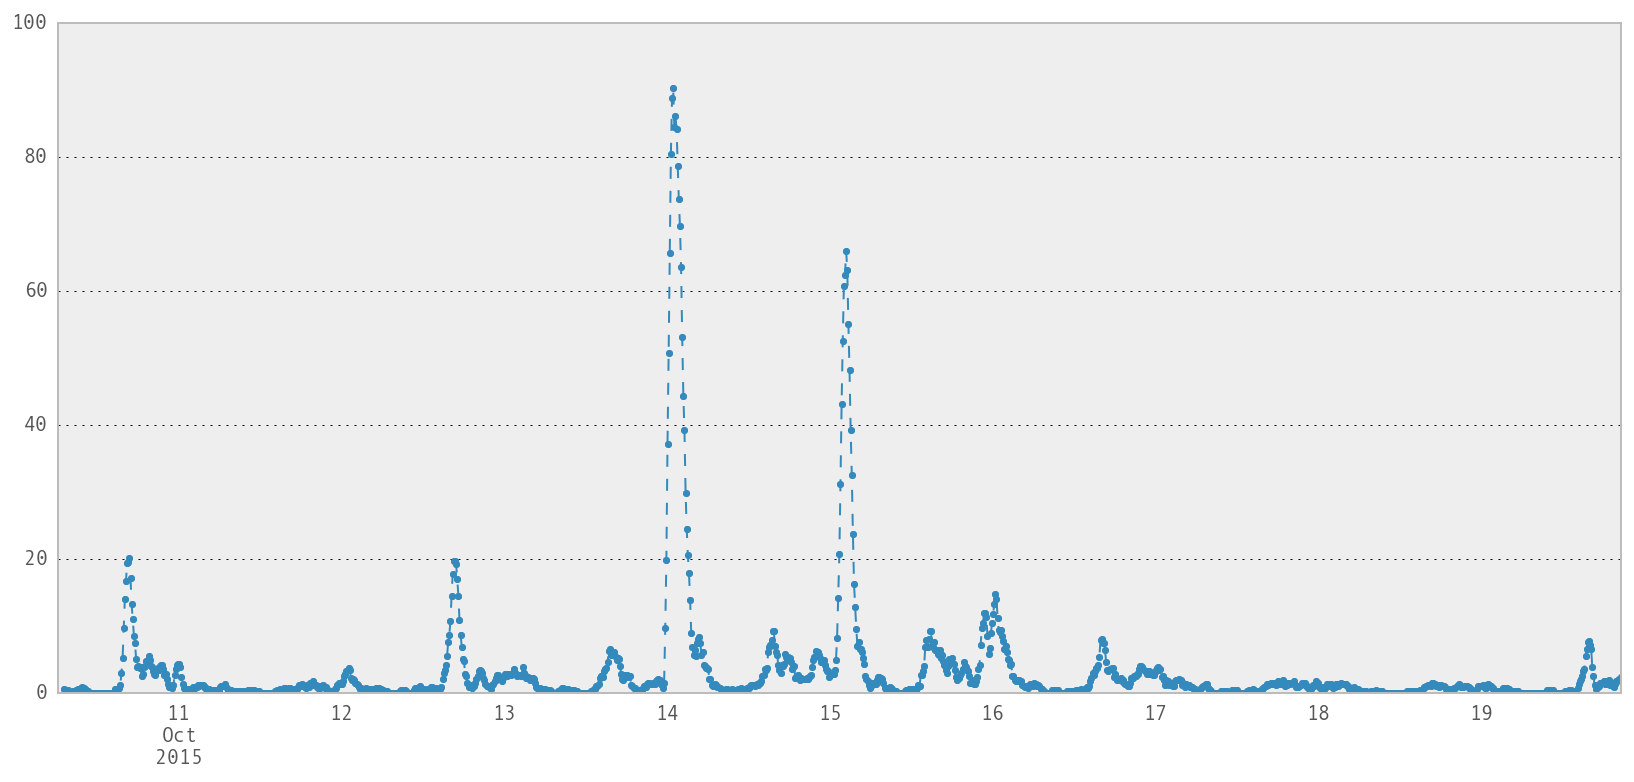

In [224]:
# Alternate way of calculating rates
resampled = dt.resample('10Min', how='sum').fillna(0)
per_hour = pd.rolling_mean(resampled, 6)
per_hour.plot(style='--.', figsize=(14,6))

## Discussion/Next Steps


* Caltrain_News is a good source of info on potentially disruptive events
    - However, not _all_ of them result in system-wide delays
    - Simple keyword matching could identify some common situations
    - But there's no standard reporting so may have false positives for predicting system-wide failures (vs long delays)

* Most robust indicator of failure is suspension of real-time API
    - Caltrain staff manually stop 'predictions' when the trains stop for catastrophic events
    - However, the scraper does not report an _absence_ of data which we need to identify a shutdown
        - [GH issue #111](https://github.com/silicon-valley-data-science/Trains/issues/111) added to add absence reporting to scraper
        - Certain stations can be 'blacklisted' because they are rarely visited and would be false positives (e.g Gilroy)
        - DS and DE need to coordinate to establish data model for these 'nulls'
    
* Usability of app would improve if it signaled users of potentially catastrophic events    

* Twitter velocity on @caltrain_news and 'caltrain' search
    - more smoothing (i.e. longer windowed average) results in fewer false positives for a simple threshold
    - BUT would increase delay between event occurence and identification, reducing timeliness of reporting to users

* Use twitter sentiment from Rick and Ben
    - May need to tune 'calamity indicator' thresholds on frequency and sentiment depending on smoothing
    - *Save these data from Kafka into HBase!!*
    
    